# under construction

## Some examples using the tools in this distribution.

### Contents

- Load an image, and downsample to a size appropriate for the machine speed.
- Synthetic images.
- Point operations (lookup tables):
- histogram Modification/matching:
- Convolution routines:
- Compare speed of convolution/downsampling routines:
- Display image and extension of left and top boundaries
    
    - for pyramids, see TUTORIALS/01_pyramids.ipynb
            Multi-scale pyramids
            A Laplacian pyramid:
            Wavelet/QMF pyramids:
            Steerable pyramid:
            Steerable pyramid, constructed in frequency domain:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyrtools as ppt
%load_ext autoreload
%autoreload 2

## Load an image, and downsample to a size appropriate for the machine speed

In [2]:
oim = plt.imread('../pyrtools/data/einsteinCorrect.pgm').astype(float)

In [3]:
filt = np.ones((2,2)) / 4

In [4]:
import time
t = time.time()
ppt.corrDn(oim, filt, edges='reflect1', step=(2, 2), start=(0, 0), stop=None, result=None)
elapsed = time.time() - t

In [5]:
imSubSample = min(max(np.floor(np.log2(elapsed)/2+3),0),2)
imSubSample

0

In [6]:
im = ppt.blurDn(oim, n_levels=imSubSample, filt='qmf9')

ShowIm: 3 types of automatic graylevel scaling, 2 types of automatic sizing, with or without title and Range information.

In [7]:
? ppt.showIm

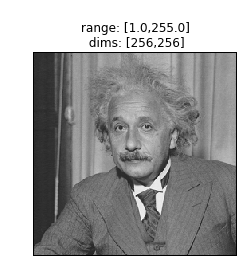

In [8]:
ppt.showIm(im)

# showIm(im,'auto1','auto','Al')

# showIm('im','auto2')

# showIm(im,'auto3',2)

## Statistics:

In [9]:
ppt.imStats(im)
ppt.imCompare(im, oim)

Image statistics:
  Range: [1.000000, 255.000000]
  Mean: 116.456772,  Stdev: 39.899688,  Kurtosis: 3.433610
Difference statistics:
  Range: [0, 0]
  Mean: 0.000000,  Stdev (rmse): 0.000000,  SNR (dB): inf


## Synthetic images

In [10]:
# pick some parameters
size      = 256
direction = 2 * np.pi * np.random.rand(1)
slope     = 10 * np.random.rand(1) - 5
intercept = 10 * np.random.rand(1) - 5
origin    = np.round(size * np.random.rand(2,1)).astype(int)
exponent  = 0.8 + np.random.rand(1)
amplitude = 1 + 5 * np.random.rand(1)
phase     = 2 * np.pi * np.random.rand(1)
period    = 20
twidth    = 7

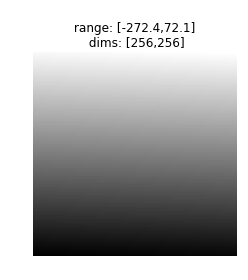

In [11]:
ppt.showIm(ppt.mkRamp(size, direction, slope, intercept, origin))

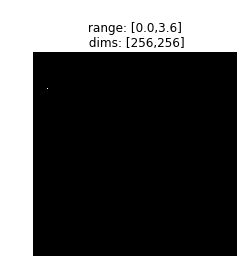

In [12]:
ppt.showIm(ppt.mkImpulse(size, origin, amplitude))

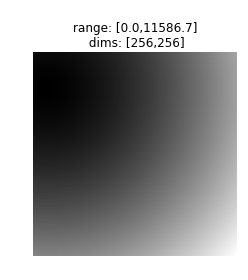

In [13]:
ppt.showIm(ppt.mkR(size, exponent, origin))

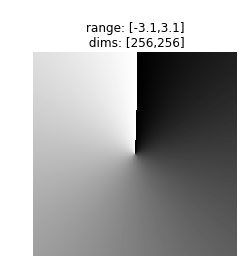

In [14]:
ppt.showIm(ppt.mkAngle(size, direction))

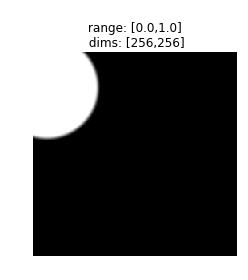

In [15]:
ppt.showIm(ppt.mkDisc(size, size/4, origin, twidth))

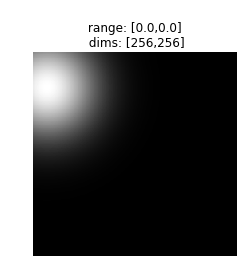

In [16]:
ppt.showIm(ppt.mkGaussian(size, (size/6)**2, origin, 'norm'))

In [17]:
# TODO fix normalization - range
g = ppt.mkGaussian(size, (size/6)**2, origin, 'norm')
g.min(), g.max()

(7.4890087440009486e-17, 8.742642137616321e-05)

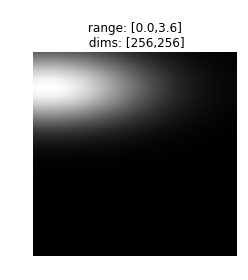

In [18]:
ppt.showIm(ppt.mkGaussian(size, ((size/8)**2,(size/3)**2), origin, amplitude))

[[ 70124. -19924.]
 [-19924.  32724.]]


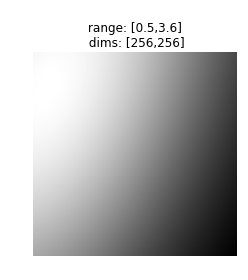

In [19]:
cov = (size * np.random.uniform(-1,1,(2,2)))
cov = cov.dot(cov.T)
print(np.round(cov))
# TODO fix

ppt.showIm(ppt.mkGaussian(size, cov, origin, amplitude))

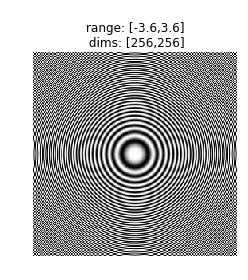

In [20]:
ppt.showIm(ppt.mkZonePlate(size, amplitude, phase))
# TODO fix aliasing

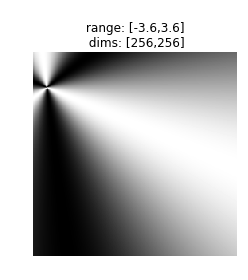

In [21]:
ppt.showIm(ppt.mkAngularSine(size, 3, amplitude, phase, origin))

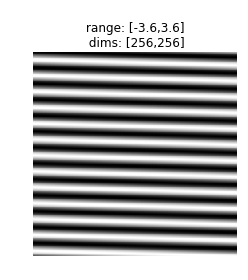

In [22]:
ppt.showIm(ppt.mkSine(size, period, direction, amplitude=amplitude, phase=phase, origin=origin))

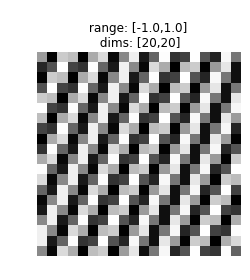

In [23]:
ppt.showIm(ppt.mkSine(20, frequency=[1,2]))

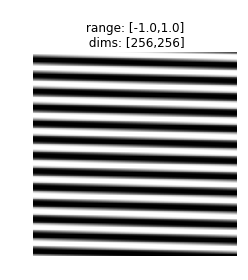

In [24]:
ppt.showIm(ppt.mkSquare(size, period, direction, amplitude, phase=phase, origin=origin, twidth=twidth))

Symmetry error in creating fractal


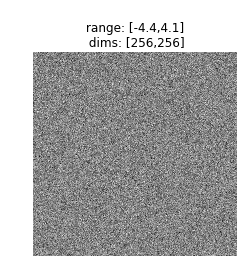

In [25]:
ppt.showIm(ppt.mkFract(size, exponent))
# TODO

## Point operations (lookup tables):

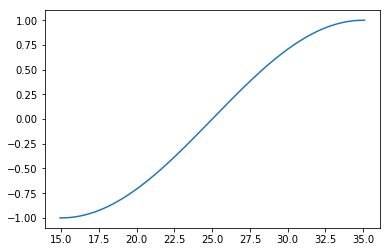

In [26]:
Xtbl,Ytbl = ppt.rcosFn(width=20, position=25, values=(-1, 1))
plt.plot(Xtbl,Ytbl)
plt.show()

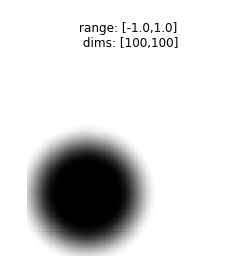

In [27]:
ppt.showIm(ppt.pointOp(ppt.mkR(100,1,[70,30]), Ytbl, Xtbl[0], Xtbl[1]-Xtbl[0], 0))

## histogram Modification/matching:

In [29]:
N, X    = ppt.matlab_histo(im, nbins=150)
mn, mx  = ppt.range2(im)

matched = ppt.histoMatch(np.random.uniform(size=im.shape), N, X)

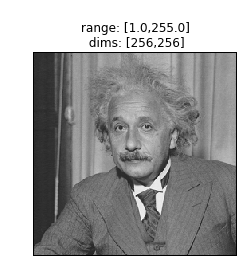

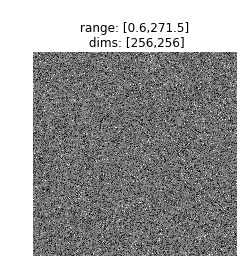

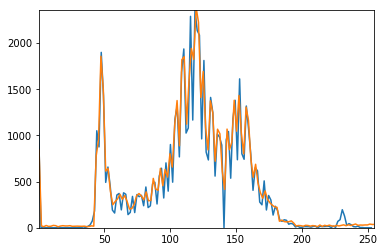

In [30]:
# TODO side by side
ppt.showIm(im)
ppt.showIm(matched)

Nm, Xm = ppt.matlab_histo(matched,150)

plt.figure()
plt.plot(X.flatten()[:-1],N.flatten())
plt.plot(Xm.flatten()[:-1],Nm.flatten())
plt.xlim([mn, mx])
plt.ylim([0, np.max(N)])
# plt.axis('off')
plt.show()

## Convolution routines: Compare speed of convolution/downsampling routines

In [31]:
k = 5
size = 2 ** 9
noise = np.random.rand(size,size)
filt  = np.random.rand(k,k)

In [32]:
%%time
res1 = ppt.corrDn(noise, np.flipud(np.fliplr(filt)), 'reflect1', step=[2, 2])

CPU times: user 5.81 ms, sys: 3.65 ms, total: 9.46 ms
Wall time: 8.09 ms


In [33]:
%%time
ires = ppt.rconv2(noise,filt)
res2 = ires[0:size:2,0:size:2]

CPU times: user 30.5 ms, sys: 16.9 ms, total: 47.4 ms
Wall time: 46.3 ms


In [34]:
ppt.imCompare(res1, res2)

Difference statistics:
  Range: [0, 0]
  Mean: -0.000000,  Stdev (rmse): 0.000000,  SNR (dB): 287.352042


In [35]:
res3 = ppt.corrDn(noise, np.flipud(np.fliplr(filt)), 'reflect1', step=[1, 1])
ppt.imCompare(res3, ires)

Difference statistics:
  Range: [0, 0]
  Mean: -0.000000,  Stdev (rmse): 0.000000,  SNR (dB): 287.340312


## Display image and extension of left and top boundaries:

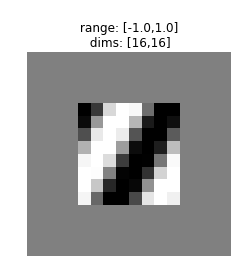

In [36]:
fsz = [9, 9]
fmid = np.ceil((fsz[0]+1)/2)
imsz = (16, 16)

# pick one:
im = np.eye(imsz[0])
im = ppt.mkRamp(imsz, np.pi/6)
im = ppt.mkSquare(imsz, 6, np.pi/6)

# pick one:
edges='reflect1'
edges='reflect2'
edges='repeat'
edges='extend'
edges='zero'
edges='circular'
edges='dont-compute'

filt = ppt.mkImpulse(fsz,[0, 0])
ppt.showIm(ppt.corrDn(im,filt,edges))

# line([0,0,imsz(2),imsz(2),0]+fmid(2)-0.5, ...
#      [0,imsz(1),imsz(1),0,0]+fmid(1)-0.5)
# title(sprintf('Edges = %s',edges))